# FAST AI JOURNEY: PART 1. LESSON 6.2.
## Documenting my fast.ai journey: AIRCRAFT CLASSIFIER PROJECT. DATA AUGMENTATION AND HEATMAPS.

In this project we will update our aircraft image classifier we bult from from scratch in the last lesson, adding Data Augmentation and exploring our data with Heatmaps.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
bs = 64

In [3]:
folder = 'military'

In [4]:
folder = 'civilian'

In [5]:
folder = 'uav'

In [6]:
path = Path('data/aircrafts')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

## Data augmentation.

In [7]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [8]:
#doc(get_transforms)

In [9]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(224, bs, 'zeros')

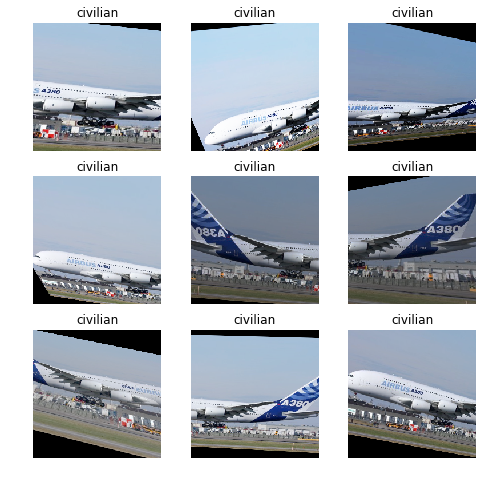

In [12]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [13]:
data = get_data(224,bs)

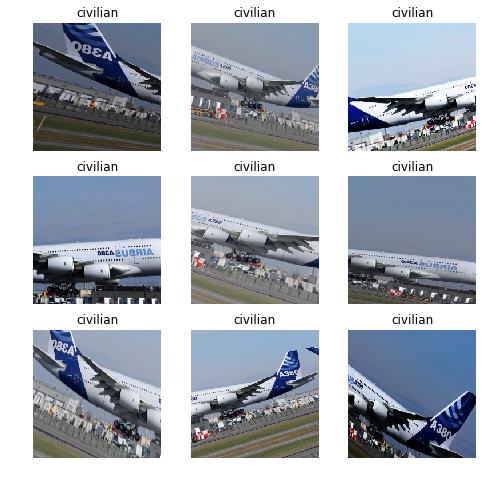

In [14]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model.

In [15]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [16]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.849122,0.489548,0.105128
2,0.693296,0.274034,0.071795
3,0.532185,0.230189,0.065385


In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.408454,0.245440,0.055128
2,0.375684,0.247576,0.047436


In [18]:
data = get_data(352,bs)
learn.data = data

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.342294,0.255184,0.047436
2,0.333227,0.261486,0.048718


In [20]:
#learn.save('352')
learn.save('stage-1-34-clean-352p')

## Convolution kernel.

In [15]:
data = get_data(352,16)

In [16]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('stage-1-34-clean-352p')

Category uav

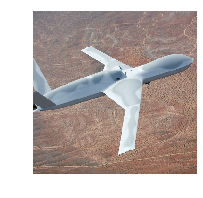

In [17]:
#idx=0
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [18]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [19]:
from fastai.callbacks.hooks import *

In [20]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [21]:
k.shape

torch.Size([1, 3, 3, 3])

In [35]:
#t = data.valid_ds[0][0].data;
t = data.valid_ds[1][0].data; t.shape

torch.Size([3, 352, 352])

In [36]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [37]:
edge = F.conv2d(t[None], k)

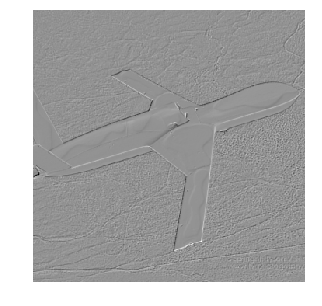

In [38]:
show_image(edge[0], figsize=(5,5));

In [56]:
data.c

3

In [57]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [58]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 176, 176]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 176, 176]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 176, 176]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 88, 88]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 88, 88]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 88, 88]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 88, 88]     0          False     
______________________________________________________________

## Heatmap.

In [39]:
m = learn.model.eval();

In [40]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [41]:
from fastai.callbacks.hooks import *

In [42]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [43]:
hook_a,hook_g = hooked_backward()

In [44]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [45]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [46]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

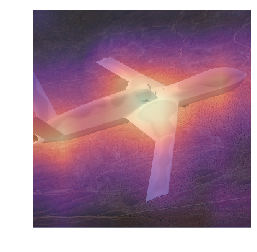

In [47]:
show_heatmap(avg_acts)

## Grad-CAM.

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [48]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [49]:
mult = (acts*grad_chan[...,None,None]).mean(0)

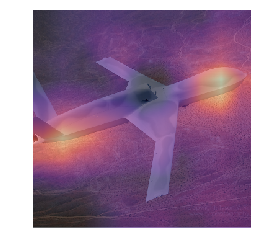

In [50]:
show_heatmap(mult)

In [51]:
fn = Path('data/aircrafts/military/00000000.jpg')

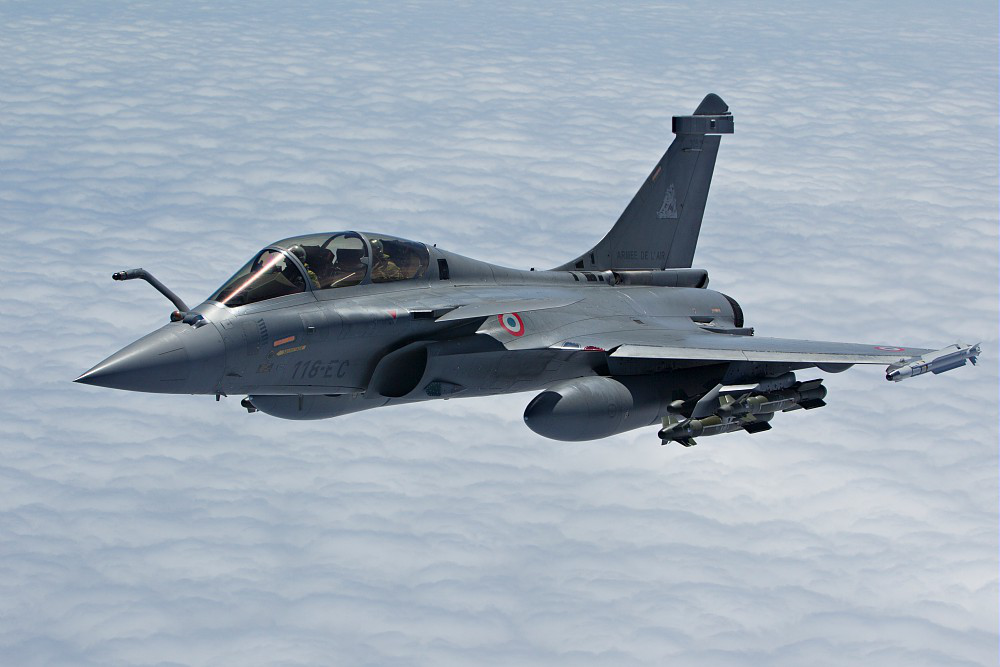

In [52]:
x = open_image(fn); x

In [53]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [54]:
hook_a,hook_g = hooked_backward()

In [55]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

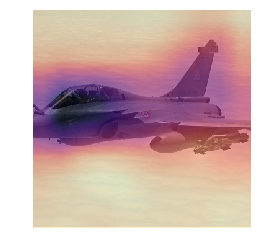

In [56]:
show_heatmap(mult)

In [57]:
data.classes[1]

'military'

In [58]:
hook_a,hook_g = hooked_backward(0)

In [59]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

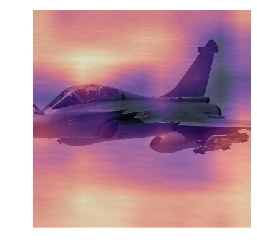

In [60]:
show_heatmap(mult)

## fin